In [1]:
library("ComplexHeatmap")
library("ggplot2")
library("circlize")
library("qpdf")

Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

In [99]:
source("/data1/weiyihu/endometrium/data/share/paraments.R")
source("/data1/weiyihu/endometrium/data/share/function.R")

In [3]:
setwd("/data1/weiyihu/endometrium/data")

In [92]:
dataHeatmap = readRDS("0005_dataHeatmap.rds")

In [46]:
calc_ht_size = function(HeatmapObject, unit="inch") {
  pdf(NULL)
  HeatmapObject = draw(HeatmapObject)
  w = ComplexHeatmap:::width(HeatmapObject)
  w = convertX(w, unit, valueOnly=TRUE)
  h = ComplexHeatmap:::height(HeatmapObject)
  h = convertY(h, unit, valueOnly=TRUE)
  dev.off()
  c(w, h)
}

In [120]:
makeHeatmap = function(df, rowSet=NULL, colSet=NULL, rowColor=NULL, colColor=NULL, rowLevels=NULL, colLevels=NULL, MEAN=FALSE){
  # input:
  #   df
  #   rowSet|\t     list|\t             key为row的分组名, value为对应分组中的rowName
  #   colSet|\t     list|\t             同上
  #   rowColor|\t   list|\t             key为row的组名, value为该组的颜色
  #   colColor|\t   list|\t             key为col的组名, value为该组的颜色
  #   rowLevels|\t  characterVector|\t  =names(rowSet), 行组的顺序
  #   colLevels|\t  characterVector|\t  =unique(colnames(df)), 列组的顺序
  #library(ComplexHeatmap)
  #library(circlize)
  #library(grDevices)
  df = df
  rowSet = rowSet
  colSet = colSet
  rowColor = rowColor
  colColor = colColor
  rowLevels = rowLevels
  colLevels = colLevels
  MEAN = MEAN

  # 初始化
  rowSet = ifelse(is.null(rowSet), list(structure(as.list(rownames(df)), names=rownames(df))), list(rowSet))[[1]]
  colSet = ifelse(is.null(colSet), list(structure(as.list(colnames(df)), names=colnames(df))), list(colSet))[[1]]
  rowColor = ifelse(is.null(rowColor), list(stats::setNames(grDevices::rainbow(length(rowSet)), names(rowSet))), list(unlist(rowColor)[names(rowColor) %in% names(rowSet)]))[[1]]
  colColor = ifelse(is.null(colColor), list(stats::setNames(grDevices::rainbow(length(colSet)), names(colSet))), list(unlist(colColor)[names(colColor) %in% names(colSet)]))[[1]]
  rowLevels = ifelse(is.null(rowLevels), list(names(rowSet)), list(rowLevels[rowLevels %in% names(rowSet)]))[[1]]
  colLevels = ifelse(is.null(colLevels), list(unique(colnames(df))), list(colLevels[colLevels %in% names(colSet)]))[[1]]

  df = as.data.frame(t(df))

  #顶部注释
  dfAnno = df
  dfAnno$column = rownames(dfAnno)
  dfAnno <- data.frame(dfAnno$column)
  dfAnno$group = NA
  for(i in seq(1, dim(dfAnno)[1])){
    colName = dfAnno[i, 1]
    for(group in names(colSet)){
      if(colName %in% colSet[[group]]){dfAnno[i, 2] = group}
    }
  }
  dfAnno = dfAnno[, 2, drop=FALSE]
  colnames(dfAnno) <- "group"
  dfAnno[, 1] = factor(dfAnno[, 1], levels=colLevels)
  splitCol = dfAnno[, 1]
  top_anno = HeatmapAnnotation(df=dfAnno,
                               border=F,
                               show_annotation_name=F,
                               gp=gpar(col=NA),
                               col=list("group"=colColor),
                               show_legend=T,
                               which='column')

  # 左侧注释
  dfAnno = df
  dfAnno = as.data.frame(t(dfAnno))
  dfAnno$rowName = rownames(dfAnno)
  dfAnno <- data.frame(dfAnno$rowName)
  dfAnno$group = NA
  for(i in seq(1, dim(dfAnno)[1])){
    rowName = dfAnno[i, 1]
    for(group in names(rowSet)){
      if(rowName %in% rowSet[[group]]){dfAnno[i, 2] = group}
    }
  }
  dfAnno = dfAnno[, 2, drop=FALSE]
  colnames(dfAnno) <- "gene set"
  dfAnno[, 1] = factor(dfAnno[, 1], levels=rowLevels)
  splitRow = dfAnno[, 1]
  left_anno = HeatmapAnnotation(df=dfAnno,
                                border=F,
                                show_annotation_name=F,
                                gp=gpar(col=NA),
                                col=list("gene set"=unlist(rowColor)),
                                show_legend=T,
                                which='row')

  # 数据标准化缩放
  marker_exp <- t(scale(df[, ], scale=T, center=T))
  marker_exp[is.na(marker_exp)] = 0
  cat(paste0("min(int): ", floor(min(marker_exp)), ' max(int): ', ceiling(max(marker_exp)), '\n'))
  
  #颜色设置
  col_fun <- colorRamp2(c(floor(min(marker_exp)), 0, ceiling(max(marker_exp))),
                        c("#313695", "white", "#A50026"))
  col_fun(seq(floor(min(marker_exp)), ceiling(max(marker_exp))))
  
  # 主图
  if(MEAN==TRUE){
    plot <- Heatmap(marker_exp,
                  row_split=splitRow,
                  column_split=splitCol,
                  cluster_row_slices=FALSE,
                  cluster_column_slices=FALSE,
                  #cluster_rows=T,  # 是否进行行聚类
                  cluster_rows=F,  # 是否进行行聚类
                  show_row_dend=FALSE,
                  cluster_columns=F,  # 是否进行列聚类
                  row_title=gt_render(c("","immune cells","GC B cells"),r=unit(2, "pt"),padding=unit(c(2,2,2,2),"pt")), # nolint: commented_code_linter.
                  row_title_side="left",
                  show_row_names=T,  # 是否显示行名
                  row_names_side='right',  # 行名的位置
                  row_names_gp=gpar(fontsize=6),  # 行名的字体
                  show_column_names=F,  # 是否显示列名
                  column_title=NULL,  # 所有行的title
                  column_names_gp=gpar(fontsize=10),  # 列名的字体
                  heatmap_legend_param=list(title=' '),
                  col=col_fun,  # 色条的设置
                  border=NULL,  # 热图最外侧边界的颜色
                  top_annotation=top_anno,
                  left_annotation=left_anno,
                  width=ncol(marker_exp)*unit(15, 'mm'),
                  height=nrow(marker_exp)*unit(2.5, 'mm')
                  )
  }else{
    plot <- Heatmap(marker_exp,
                  row_split=splitRow,
                  column_split=splitCol,
                  cluster_row_slices=FALSE,
                  cluster_column_slices=FALSE,
                  #cluster_rows=T,  # 是否进行行聚类
                  cluster_rows=F,  # 是否进行行聚类
                  show_row_dend=FALSE,
                  cluster_columns=F,  # 是否进行列聚类
                  row_title=gt_render(c("","immune cells","GC B cells"),r=unit(2, "pt"),padding=unit(c(2,2,2,2),"pt")), # nolint: commented_code_linter.
                  row_title_side="left",
                  show_row_names=T,  # 是否显示行名
                  row_names_side='right',  # 行名的位置
                  row_names_gp=gpar(fontsize=6),  # 行名的字体
                  show_column_names=F,  # 是否显示列名
                  column_title=NULL,  # 所有行的title
                  column_names_gp=gpar(fontsize=10),  # 列名的字体
                  heatmap_legend_param=list(title=' '),
                  col=col_fun,  # 色条的设置
                  border=NULL,  # 热图最外侧边界的颜色
                  top_annotation=top_anno,
                  left_annotation=left_anno,
                  height=nrow(marker_exp)*unit(2.5, 'mm')
                  )
  }


  return(plot)
}

In [121]:
plot1 = makeHeatmap(df=dataHeatmap$raw,
                    rowSet=c(geneSet[["immune"]], geneSet[["GC"]]),
                    colSet=sampleInGroup[["group2"]],
                    rowColor=geneSetColors,
                    colColor=groupColors,
                    rowLevels=c('LymphocyteRecruitment','Chemokines','Proliferation'),
                    colLevels=levels(groupLevels[["group2"]])
                    )

min(int): -3 max(int): 11


In [122]:
plot2 = makeHeatmap(df=dataHeatmap$rawMean,
                    rowSet=c(geneSet[["immune"]], geneSet[["GC"]]),
                    colSet=NULL,
                    rowColor=geneSetColors,
                    colColor=groupColors,
                    rowLevels=c('LymphocyteRecruitment','Chemokines','Proliferation'),
                    colLevels=levels(groupLevels[["group2"]]),
                    MEAN=TRUE
                    )

min(int): -2 max(int): 2


In [123]:
plot3 = makeHeatmap(df=dataHeatmap$filter,
                    rowSet=c(geneSet[["immune"]], geneSet[["GC"]]),
                    colSet=sampleInGroup[["group2"]],
                    rowColor=geneSetColors,
                    colColor=groupColors,
                    rowLevels=c('LymphocyteRecruitment','Chemokines','Proliferation'),
                    colLevels=levels(groupLevels[["group2"]])
                    )

min(int): -3 max(int): 11


In [124]:
plot4 = makeHeatmap(df=dataHeatmap$filterMean,
                    rowSet=c(geneSet[["immune"]], geneSet[["GC"]]),
                    colSet=NULL,
                    rowColor=geneSetColors,
                    colColor=groupColors,
                    rowLevels=c('LymphocyteRecruitment','Chemokines','Proliferation'),
                    colLevels=levels(groupLevels[["group2"]]),
                    MEAN=TRUE
                    )

min(int): -2 max(int): 2


In [125]:
wh = calc_ht_size(plot1, "inch")
pdf("temp1.pdf", width=ceiling(wh[1]), height=ceiling(wh[2]))
plot1
dev.off()
wh = calc_ht_size(plot2, "inch")
pdf("temp2.pdf", width=ceiling(wh[1]), height=ceiling(wh[2]))
plot2
dev.off()
wh = calc_ht_size(plot3, "inch")
pdf("temp3.pdf", width=ceiling(wh[1]), height=ceiling(wh[2]))
plot3
dev.off()
wh = calc_ht_size(plot4, "inch")
pdf("temp4.pdf", width=ceiling(wh[1]), height=ceiling(wh[2]))
plot4
dev.off()
qpdf::pdf_combine(c("temp1.pdf", "temp2.pdf", "temp3.pdf", "temp4.pdf"),
                  "0005_plot.pdf")
file.remove(c("temp1.pdf", "temp2.pdf", "temp3.pdf", "temp4.pdf"))

Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied colo

png 
  2

Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied colo

png 
  2

Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied colo

png 
  2

Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied colo

png 
  2

[1] "/data1/weiyihu/endometrium/data/0005_plot.pdf"

[1] TRUE TRUE TRUE TRUE

In [38]:
d = Heatmap(matrix(rnorm(100), 10), 
    heatmap_legend_param = list(
        title = "rnorm", at = c(-2, 0, 2), 
        labels = c("neg_two", "zero", "pos_two")
    ),
    top_annotation = HeatmapAnnotation(
        foo = 1:10,
        annotation_legend_param = list(foo = list(title = "foo_top_anno"))
    ))

In [44]:
col_fun = colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))
lgd = Legend(col_fun = col_fun, title = "foo")

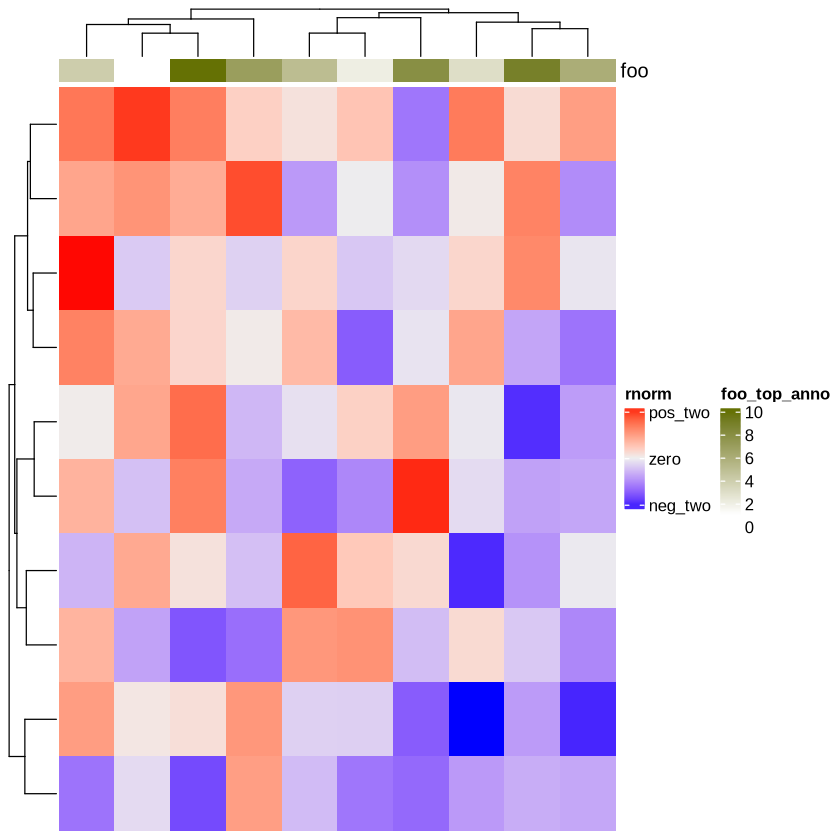

In [39]:
d